In [1]:
%config IPCompleter.greedy=True

# Phase 3 Project
## Ryan McArthur, DS FT 081720
### Instructor : Rafa Carrasco

# SyriaTel Customer Churn 

* Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company. Note that this is a binary classification problem.

* Most naturally, your audience here would be the telecom business itself, interested in losing money on customers who don't stick around very long. Are there any predictable patterns here?

In this investigation on churn for SyriaTel, we will be predicting whether or not a customer will be cancelling their phone plan with SyriaTel. In order to accomplish this, we have been provided with a dataset that includes information regarding customers' phone plan specifics, their phone usage, and their service history. 

Furthermore, we will be providing recommendations on how SyriaTel may retain customers more efficiently through the lens of our model. We will inspect which variables had large impacts on customers' decisions to cancel their plan, and suggest campaigns or incentives that will most likely change our customers decisions to leave the service, or retain existing customers for a longer period. 

Finally, we will request additional resources or information to SyriaTel in order to show how this process could have been, or could be, improved upon for further investiations.

# Data Info

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

df = pd.read_csv('Data/telecom_data.csv')
df.shape

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [3]:
sns.__version__

'0.11.0'

In [4]:
# First we have to handle the spaces in our columns name. 

df.columns = df.columns.str.strip().str.replace(' ', '_')

Our data is collected from a telecom provider with national coverage, representing one month's worth of data on a customer, describing the plan, usage, and service details. 

In [5]:
# Defining our columns:
# Target Variable:
y = df['churn']

# Categorical & Numerical Columns:
catts = []
numms = []


for i in df.columns:
    if df[i].dtype == 'object':
        catts.append(i)
    else:
        numms.append(i)

In [6]:
catts, numms
# area code should be categorical

catts.append('area_code')
numms.remove('area_code')



In [7]:
df['area_code'] = df['area_code'].astype('object')

In [8]:
catts, numms

# we are using these lists to sort our predictors for use in future loops and such. Remove churn from numms
numms.remove('churn')

In [9]:
df['churn'].sum()/len(df)

0.14491449144914492

# 14.5% of our customers churned in the last month, a more than 1:6 class imbalance. We will need to address this in our model formulation stage. 

# Data Cleaning

In [10]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [11]:
# phone number is just a unique identifier in this dataframe, can be dropped.

def drop_cols(df, columns):
    for col in columns:
        if col in df.columns:
            df.drop(columns = col, inplace = True)
        if col in catts:
            catts.remove(col)
        if col in numms:
            numms.remove(col)
        else:
            pass
drop_cols(df, ['phone_number'])
df


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [12]:
df['area_code'].value_counts()

415    1655
510     840
408     838
Name: area_code, dtype: int64

In [13]:
# for sake of ease, let's change churn from boolean to integer.
df['churn'] *= 1
# as well as the plan columns, these should be changed from yes to 1 or no to 0.
for i in range(len(df)):
    if df['international_plan'][i] == 'yes':
        df['international_plan'][i] = 1
    else: 
        df['international_plan'][i] = 0
    if df['voice_mail_plan'][i] == 'yes':
        df['voice_mail_plan'][i] = 1
    else: 
        df['voice_mail_plan'][i] = 0
df[['churn', 'international_plan', 'voice_mail_plan']].astype(int)

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,churn,international_plan,voice_mail_plan
0,0,0,1
1,0,0,1
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
3328,0,0,1
3329,0,0,0
3330,0,0,0
3331,0,1,0


In [14]:
# there isn't a 'total_charges' column, 'total_calls' column, or a 'total_minutes' column 
df['total_charge'] = df.total_day_charge+df.total_eve_charge+df.total_night_charge+df.total_intl_charge
df['total_calls'] = df.total_day_calls+df.total_eve_calls+df.total_night_calls+df.total_intl_calls
df['total_minutes'] = df.total_day_minutes+df.total_eve_minutes+df.total_night_minutes+df.total_intl_minutes

numms.append('total_charge')
numms.append('total_minutes')
numms.append('total_calls')

In [15]:
# from the total charges column, it looks like this dataframe is using a 1-month time period. This is important 
# to contextualize our findings for the presentation, so we can say we are losing X customers per TIME unit, which is 
# easier to understand than just saying CHURN RATE IS BLAH.

In [16]:
# checking for nulls or NAs
df.columns[df.isnull().any()]
# none of our columns have null values

Index([], dtype='object')

In [17]:
# how are our predictors distributed? if they are not normally distributed, how will we be dealing with this?
#pd.plotting.scatter_matrix(df, figsize = (20, 20))
plt.show()


In [18]:
# upon inspection of the scatter matrix, the following columns are NOT normally distributed:
# area_code, number_vmail_messages, and number_customer_service_calls

# Data Exploration

In [19]:
# how does total_charge as defined above relate to customer churn?

df['total_charge'].where(df['churn'] == 1).describe()

count    483.000000
mean      65.355963
std       13.885268
min       22.930000
25%       53.425000
50%       66.910000
75%       76.655000
max       96.150000
Name: total_charge, dtype: float64

In [20]:
df['total_charge'].describe()

count    3333.000000
mean       59.449754
std        10.502261
min        22.930000
25%        52.380000
50%        59.470000
75%        66.480000
max        96.150000
Name: total_charge, dtype: float64

Text(0.5, 6.79999999999999, 'Total Charge')

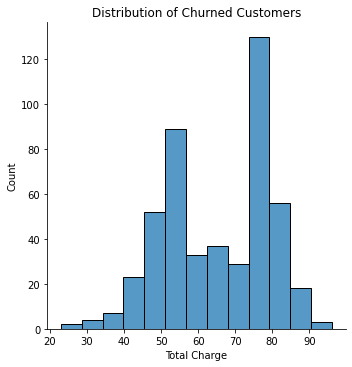

In [21]:
# both the min payer and the max payer churned out last month.

#visualizing churned customers
sns.displot(data = df.where(df['churn']==1), x = 'total_charge')
plt.title('Distribution of Churned Customers')
plt.xlabel('Total Charge')

Text(0.5, 6.79999999999999, 'Total Charge')

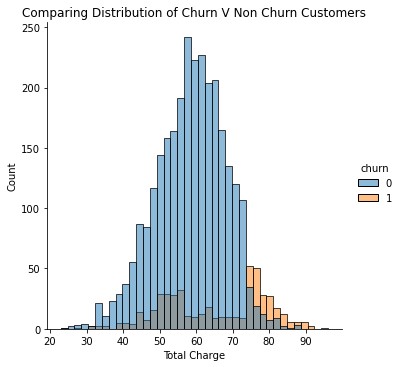

In [22]:
#comparing these churned customers to non churned 
sns.displot(data = df, x = 'total_charge', hue = 'churn')
plt.title('Comparing Distribution of Churn V Non Churn Customers')
plt.xlabel('Total Charge')

In [23]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,total_calls,total_minutes
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,...,91,11.01,10.0,3,2.70,1,0,75.56,303,717.2
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,...,103,11.45,13.7,3,3.70,1,0,59.24,332,625.2
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,...,104,7.32,12.2,5,3.29,0,0,62.29,333,539.4
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,...,89,8.86,6.6,7,1.78,2,0,66.80,255,564.8
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,...,121,8.41,10.1,3,2.73,3,0,52.09,359,512.0


<AxesSubplot:xlabel='customer_service_calls', ylabel='total_charge'>

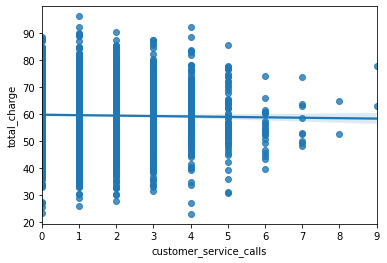

In [24]:
sns.regplot(data = df, x = 'customer_service_calls', y = 'total_charge')

<AxesSubplot:xlabel='account_length', ylabel='total_charge'>

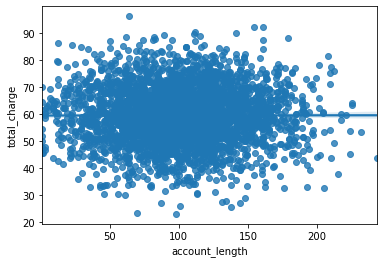

In [25]:
sns.regplot(data = df, x = 'account_length', y = 'total_charge')

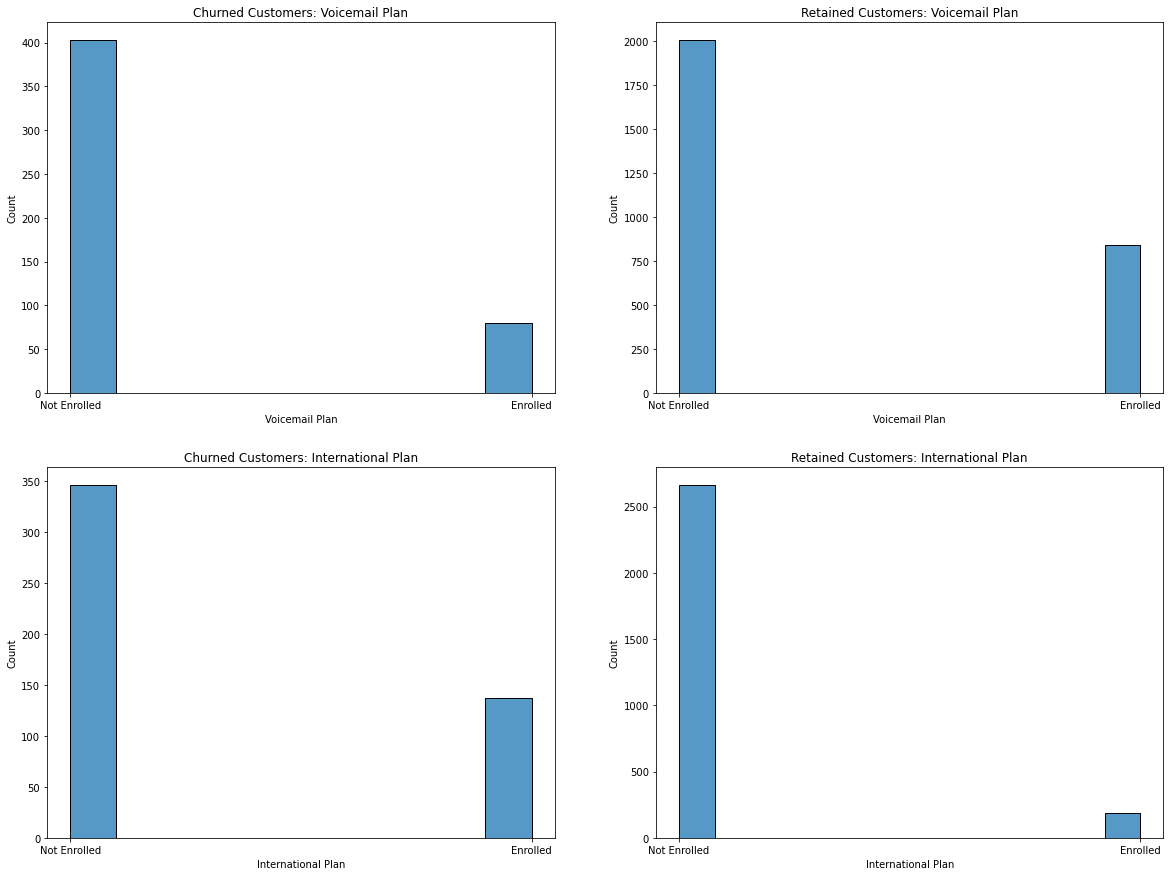

In [26]:
# does being enrolled in an additional plan (voicemail or intl) contribute to higher payments? Or higher churn?
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))

x_range = [0, 1]
x_labels = ['Not Enrolled', 'Enrolled']

sns.histplot(ax = axes[0][0], data = df.where(df['churn']==1), x = 'voice_mail_plan').set(xlabel = "Voicemail Plan", xticks=x_range, xticklabels = x_labels, title = 'Churned Customers: Voicemail Plan')
sns.histplot(ax = axes[0][1], data = df.where(df['churn']==0), x = 'voice_mail_plan').set(xlabel = "Voicemail Plan", xticks=x_range, xticklabels = x_labels, title = 'Retained Customers: Voicemail Plan')
sns.histplot(ax = axes[1][0], data = df.where(df['churn']==1), x = 'international_plan').set(xlabel = "International Plan", xticks=x_range, xticklabels = x_labels, title = 'Churned Customers: International Plan')
sns.histplot(ax = axes[1][1], data = df.where(df['churn']==0), x = 'international_plan').set(xlabel = "International Plan", xticks=x_range, xticklabels = x_labels, title = 'Retained Customers: International Plan')
plt.show()



In [27]:
# what if a customer is enrolled in both?
df_voice = df.where(df.voice_mail_plan == 1)
df_voice.dropna()
df_both_plans = df_voice.where(df.international_plan == 1)
df_both_plans = df_both_plans.dropna()
(len(df_both_plans) / len(df))*100
# only 2.8 % of customers are subscribed to both international and voicemail plans, we shouldn't do much investigation on 
# such a small subset of our customer base. 

2.7602760276027603

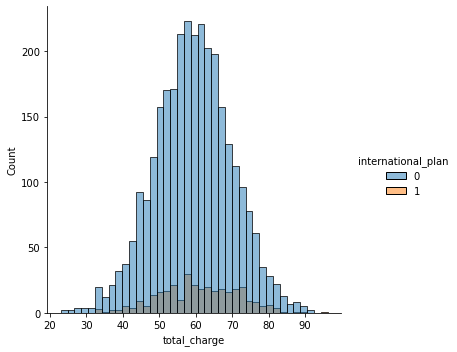

In [28]:
sns.displot(data = df, x = 'total_charge', hue = 'international_plan')

In [29]:
# what does each state pay for this phone service on average?
# what is the churn rate for each state?
# how does churn rate compare to total charge by state? 

#total cost
df_states = pd.DataFrame(df.groupby('state')['total_charge'].mean())
df_states = df_states.sort_values(['total_charge'])
df_states = df_states.reset_index()

#churn 
df_states_churn = pd.DataFrame(df.groupby('state')['churn'].sum())
df_states_churn = df_states_churn.sort_values(['churn'])
df_states_churn = df_states_churn.reset_index()
df_states['churn_sum'] = df_states_churn['churn']
df_states

,state,total_charge,churn_sum
0,AZ,56.733281,3
1,AK,57.350192,3
2,WV,57.353585,3
3,SC,57.388000,4
4,IL,57.922931,4
5,DC,57.969815,5
6,KY,58.022712,5
7,HI,58.059434,5
8,MO,58.141429,5
9,RI,58.265231,5


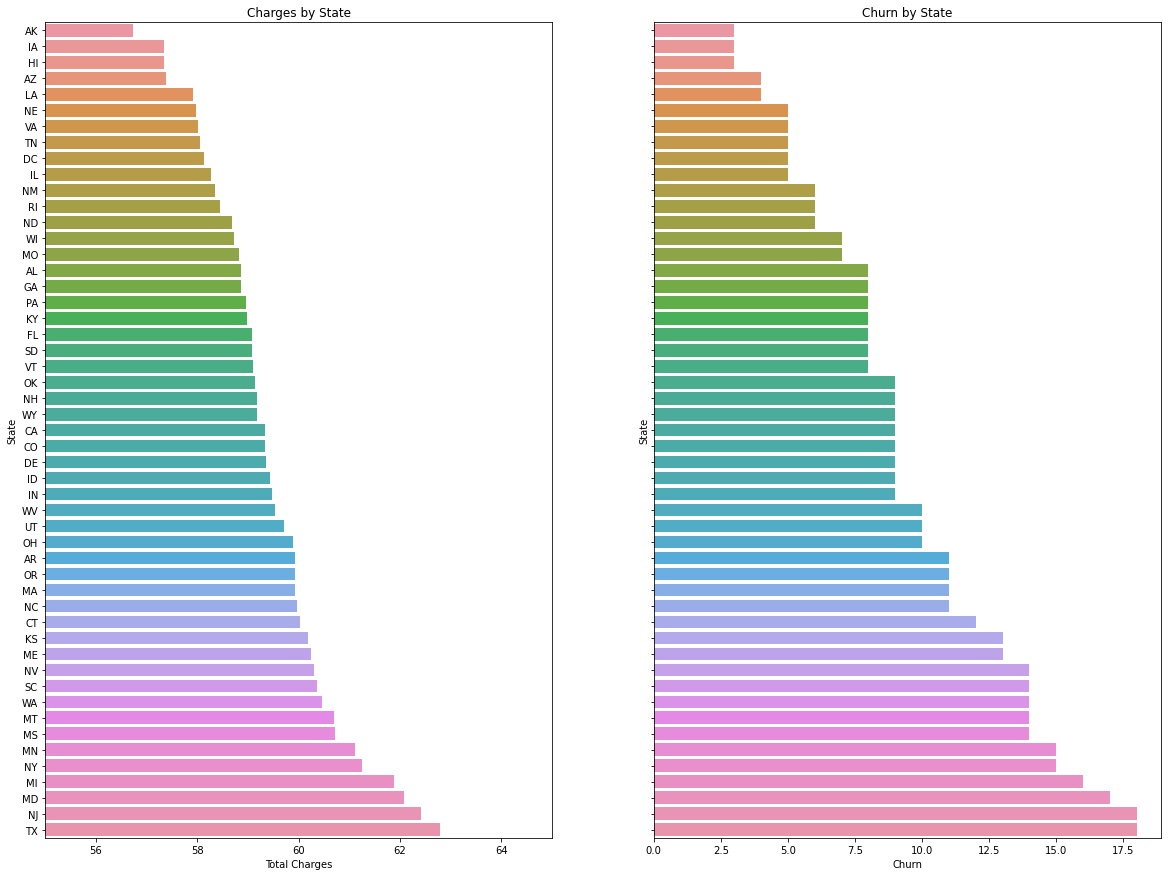

In [30]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 15), sharey = True)
sns.barplot(ax = axes[0], y = df_states['state'], x = df_states['total_charge']).set(xlim = [55, 65], title = "Charges by State", xlabel = "Total Charges", ylabel = 'State')
sns.barplot(ax = axes[1], y = df_states_churn['state'], x = df_states_churn['churn']).set(title = 'Churn by State', xlabel = "Churn", ylabel = 'State')
plt.show()


Classifying on 1 or 0, logistic regression checks: we need to check if there is much overlap between churn = 1 and churn = 0 for each of our predictors. More overlap means that logistic regression is less applicable. 

A note on our features:
* We need to choose between using totals versus breakdowns of minutes, charge, and calls. Including all of these columns will lead to intense multicollinearity issues, so it is best to drop what will impede us now. 
* let us drop charge breakdowns, using only Total_charge. 
* let us keep minutes and call breakdowns, dropping Total_minutes and Total_calls. 

In [31]:
drop_cols(df, ['total_day_charge', 'total_night_charge', 'total_eve_charge', 'total_intl_charge', 'total_calls', 'total_minutes'])

In [32]:
df.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_eve_minutes', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'customer_service_calls', 'churn', 'total_charge'],
      dtype='object')

In [33]:
df.shape

(3333, 17)

In [34]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09


In [35]:
catts, numms

(['state', 'international_plan', 'voice_mail_plan', 'area_code'],
 ['account_length',
  'number_vmail_messages',
  'total_day_minutes',
  'total_day_calls',
  'total_eve_minutes',
  'total_eve_calls',
  'total_night_minutes',
  'total_night_calls',
  'total_intl_minutes',
  'total_intl_calls',
  'customer_service_calls',
  'total_charge'])

And we also need to encode categorical predictors. Before we do so, however, we need to address 'area_code', a problematic column. There are only three unique values in this column, all area codes belonging to the San Francisco Bay area, while we also have the 'states' column that contradicts this fact. Because of this, we will be dropping 'area_code'. 

In [36]:
drop_cols(df, ['area_code'])
df
df_clean = pd.get_dummies(data = df, columns = ['state'])
df_clean

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,25,265.1,110,197.4,99,244.7,91,...,0,0,0,0,0,0,0,0,0,0
1,107,0,1,26,161.6,123,195.5,103,254.4,103,...,0,0,0,0,0,0,0,0,0,0
2,137,0,0,0,243.4,114,121.2,110,162.6,104,...,0,0,0,0,0,0,0,0,0,0
3,84,1,0,0,299.4,71,61.9,88,196.9,89,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,0,166.7,113,148.3,122,186.9,121,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,215.5,126,279.1,83,...,0,0,0,0,0,0,0,0,0,0
3329,68,0,0,0,231.1,57,153.4,55,191.3,123,...,0,0,0,0,0,0,0,0,1,0
3330,28,0,0,0,180.8,109,288.8,58,191.9,91,...,0,0,0,0,0,0,0,0,0,0
3331,184,1,0,0,213.8,105,159.6,84,139.2,137,...,0,0,0,0,0,0,0,0,0,0


We have completed the process of introducing, exploring, and cleaning our data. In the next stage, contained in the notebook titled 'Model Construction', we will begin to formulate which model will be most appropriate to accomplish our goal of constructing a model that will best allow SyriaTel to retain customers at risk of churning. 

In [37]:
df.to_csv(r'..\dsc-phase-3-project\Data\cleaned_data.csv')

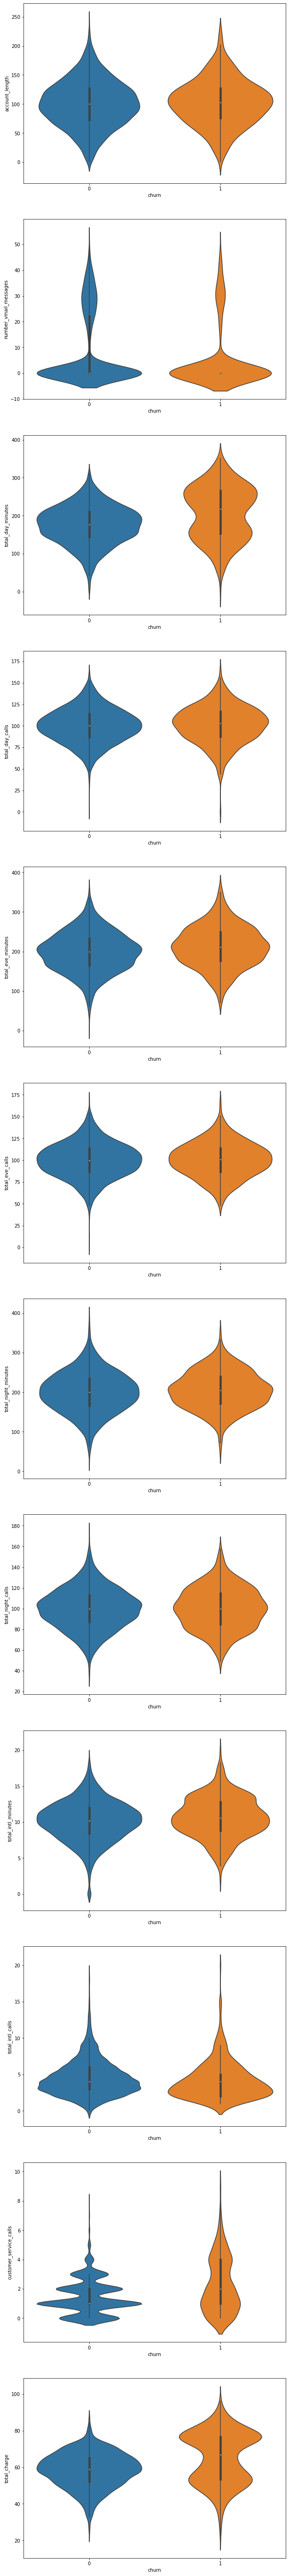

In [38]:
#comparing violin plots w/ churn hue to see if there is inacceptable overlap within our predictors. 

fig, axes = plt.subplots(nrows = 12, ncols = 1, figsize = (10, 100))

for i, col in enumerate(numms):
    sns.violinplot(data = df, ax = axes[i], y = col, x = 'churn')

We can see above that there is heavy overlap between Churned and Retained for most of our predictors. Because of this, logistic regression is not the best path forward. Instead, we will investigate different types of ensemble methods. First we will attempt a Random Forest, and then refine this Random Forest with an ADABoosted model. 

In [64]:
df

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0,60.10
3329,WV,68,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0,63.53
3330,RI,28,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0,67.74
3331,CT,184,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0,57.53


In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, recall_score, make_scorer

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
df_train, df_validation = train_test_split(df, test_size=0.10)

In [42]:
clf = RandomForestClassifier()

In [43]:
params = {
    "n_estimators": [10, 20, 50],
    "max_depth": [3, 8, 10]
}

In [44]:
gs_cv = GridSearchCV(clf, param_grid=params, n_jobs=-1, verbose=2, scoring=make_scorer(recall_score))

In [56]:
def get_xy(df, drops, target):
    X = df.drop(columns = drops)
    y = df['churn']
    return X, y


X_train, y_train = get_xy(df_train, drops = ['state', 'churn'], target = 'churn')
X_validation, y_validation = get_xy(df_validation, drops = ['state', 'churn'], target = 'churn')
gs_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 8, 10], 'n_estimators': [10, 20, 50]},
             scoring=make_scorer(recall_score), verbose=2)

In [57]:
gs_results_df = pd.DataFrame(gs_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025333,0.001353,0.005585,2.720666e-03,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.344828,0.379310,0.425287,0.379310,0.448276,0.395402,0.036782,9
1,0.045278,0.003969,0.005385,7.980588e-04,3,20,"{'max_depth': 3, 'n_estimators': 20}",0.367816,0.379310,0.390805,0.436782,0.425287,0.400000,0.026611,8
2,0.098137,0.003191,0.007979,6.307510e-04,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.356322,0.379310,0.402299,0.448276,0.471264,0.411494,0.042637,7
3,0.032712,0.002309,0.003990,3.989506e-07,8,10,"{'max_depth': 8, 'n_estimators': 10}",0.666667,0.643678,0.827586,0.873563,0.781609,0.758621,0.089626,6
4,0.060438,0.002570,0.005784,1.162958e-03,8,20,"{'max_depth': 8, 'n_estimators': 20}",0.816092,0.793103,0.781609,0.839080,0.747126,0.795402,0.031183,3


In [58]:
best_clf = gs_cv.best_estimator_

In [59]:
best_clf.score(X_train, y_train)

0.9813271090363455

In [60]:
best_clf.score(X_validation, y_validation)

0.9790419161676647

In [61]:
# look at feature importances
features = X_train.columns
feature_importances = best_clf.feature_importances_

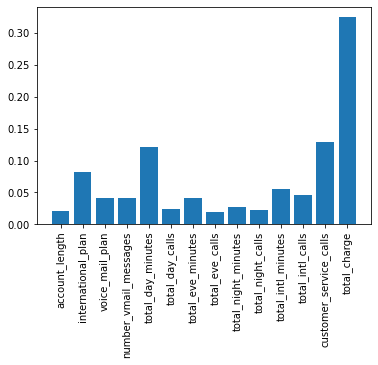

In [62]:
plt.bar(features, feature_importances)
plt.xticks(rotation=90)
plt.show()

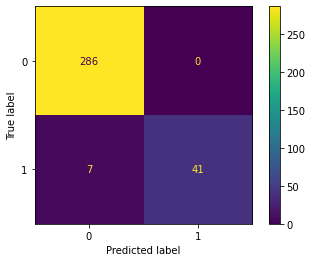

In [63]:
plot_confusion_matrix(best_clf, X_validation, y_validation)